<a href="https://colab.research.google.com/github/Satwikram/Named-Entity-Recognition/blob/main/Named%20Entity%20Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Author: Satwik Ram K

**Named Entity Recognition using Bi-Directional LSTM**

### Data Description

**Context:**

Annotated Corpus for Named Entity Recognition using GMB(Groningen Meaning Bank) corpus for entity classification with enhanced and popular features by Natural Language Processing applied to the data set.

Number of tagged entities:

'O': 1146068', geo-nam': 58388, 'org-nam': 48034, 'per-nam': 23790, 'gpe-nam': 20680, 'tim-dat': 12786, 'tim-dow': 11404, 'per-tit': 9800, 'per-fam': 8152, 'tim-yoc': 5290, 'tim-moy': 4262, 'per-giv': 2413, 'tim-clo': 891, 'art-nam': 866, 'eve-nam': 602, 'nat-nam': 300, 'tim-nam': 146, 'eve-ord': 107, 'per-ini': 60, 'org-leg': 60, 'per-ord': 38, 'tim-dom': 10, 'per-mid': 1, 'art-add': 1

**Essential info about entities:**

geo = Geographical Entity

org = Organization

per = Person

gpe = Geopolitical Entity

tim = Time indicator

art = Artifact

eve = Event

nat = Natural Phenomenon

Total Words Count = 1354149
Target Data Column: "tag"

### Connecting Kaggle

In [2]:
from google.colab import files

files.upload()


! mkdir ~/.kaggle


! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d abhinavwalia95/entity-annotated-corpus

100% 26.4M/26.4M [00:00<00:00, 15.9MB/s]



In [4]:
!unzip /content/entity-annotated-corpus.zip

Archive:  /content/entity-annotated-corpus.zip
  inflating: ner.csv                 
  inflating: ner_dataset.csv         


### Importing Librarries

In [5]:
import numpy as np
import pandas as pd

In [6]:
dataset = pd.read_csv('/content/ner_dataset.csv', encoding = "latin1")

In [7]:
dataset.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [8]:
dataset.tail()

,Sentence #,Word,POS,Tag
1048570,NaN,they,PRP,O
1048571,NaN,responded,VBD,O
1048572,NaN,to,TO,O
1048573,NaN,the,DT,O
1048574,NaN,attack,NN,O


### Checking for Count of NaN Values

In [9]:
dataset.isna().sum()

Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

### Filling Missing Values

In [10]:
dataset.fillna(method = 'ffill', inplace = True)

In [11]:
dataset.isna().sum()

Sentence #    0
Word          0
POS           0
Tag           0
dtype: int64

In [57]:
dataset.tail(20)

,Sentence #,Word,POS,Tag
1048555,Sentence: 47957,.,.,O
1048556,Sentence: 47958,They,PRP,O
1048557,Sentence: 47958,say,VBP,O
1048558,Sentence: 47958,not,RB,O
1048559,Sentence: 47958,all,DT,O
1048560,Sentence: 47958,of,IN,O
1048561,Sentence: 47958,the,DT,O
1048562,Sentence: 47958,rockets,NNS,O
1048563,Sentence: 47958,exploded,VBD,O
1048564,Sentence: 47958,upon,IN,O


### Getting Unique Values

In [17]:
print(dataset['Tag'].unique())

['O' 'B-geo' 'B-gpe' 'B-per' 'I-geo' 'B-org' 'I-org' 'B-tim' 'B-art'
 'I-art' 'I-per' 'I-gpe' 'I-tim' 'B-nat' 'B-eve' 'I-eve' 'I-nat']


In [22]:
print(dataset['Word'].nunique())

35178


In [23]:
words = list(set(dataset['Word'].values))

In [25]:
words.append("ENDPAD")

In [26]:
num_words = len(words)

In [27]:
tags = list(set(dataset['Tag'].values))

In [28]:
num_tags = len(tags)

### Retrieve Sentences and Corresponding Tags

In [36]:
class SentenceGetter(object):
  def __init__(self, data):
    self.n_sent = 1
    self.data = data

    agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                       s['POS'].values.tolist(),
                                                       s['Tag'].values.tolist())] 
                
    self.grouped = self.data.groupby("Sentence #").apply(agg_func)
    self.sentences = [s for s in self.grouped]

In [37]:
getter = SentenceGetter(dataset)
sentences = getter.sentences

In [38]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

### Defining Mappings Between Sentences and Tags

In [39]:
word2idx = {w: i+1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

### Padding Input Sentences and Taking X and Y

In [46]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model, to_categorical

In [47]:
max_len = 50

In [48]:
X = [[word2idx[w[0]] for w in s ] for s in sentences]
X = pad_sequences(maxlen = max_len, sequences = X, padding = 'post', value = num_words -1)

In [50]:
X[0]

array([18412, 21449,  4405, 28237, 14361,  4448, 28614,  9601, 33722,
       33357, 28275,  4023, 17271, 21514, 23275, 33357, 26736, 21449,
        4845, 15237, 24604, 22450, 32441, 14341, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178], dtype=int32)

In [59]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen = max_len, sequences = y, padding = 'post', value = tag2idx['O'])
y = [to_categorical(i, num_classes = num_tags) for i in y]

In [63]:
y[0]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

### Splitting Data into Train and Test

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 1)

In [87]:
len(X_train)

43163

In [88]:
len(y_train)

43163

In [93]:
y_train = np.array(y_train)
y_test = np.array(y_test)

### Building Bi-Directional LSTM Model

In [65]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

In [67]:
input_word = Input(shape = (max_len,))
model = Embedding(input_dim = num_words, output_dim = max_len, input_length = max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units = 100, return_sequences = True, recurrent_dropout = 0.1))(model)
out = TimeDistributed(Dense(num_tags, activation = 'softmax'))(model)

In [68]:
model = Model(input_word, out)

In [69]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 50)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


### Compiling the Model

In [70]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

### Callbacks

In [ ]:
!pip install livelossplot

In [96]:
from tensorflow.keras.callbacks import *
from livelossplot.tf_keras import PlotLossesCallback
from livelossplot import PlotLossesKeras

In [99]:
checkpoint = ModelCheckpoint('ner.hdf5',
                              monitor = 'val_loss',
                              save_best_only = True,
                              verbose = 1)

In [100]:
earlystopping = EarlyStopping( monitor = 'val_loss', verbose = 1, restore_best_weights = True,
                                                 patience = 5)

In [101]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience = 3, min_lr=0.001, verbose = 1)

In [102]:
callbacks = [checkpoint, earlystopping, reduce_lr, PlotLossesKeras()]

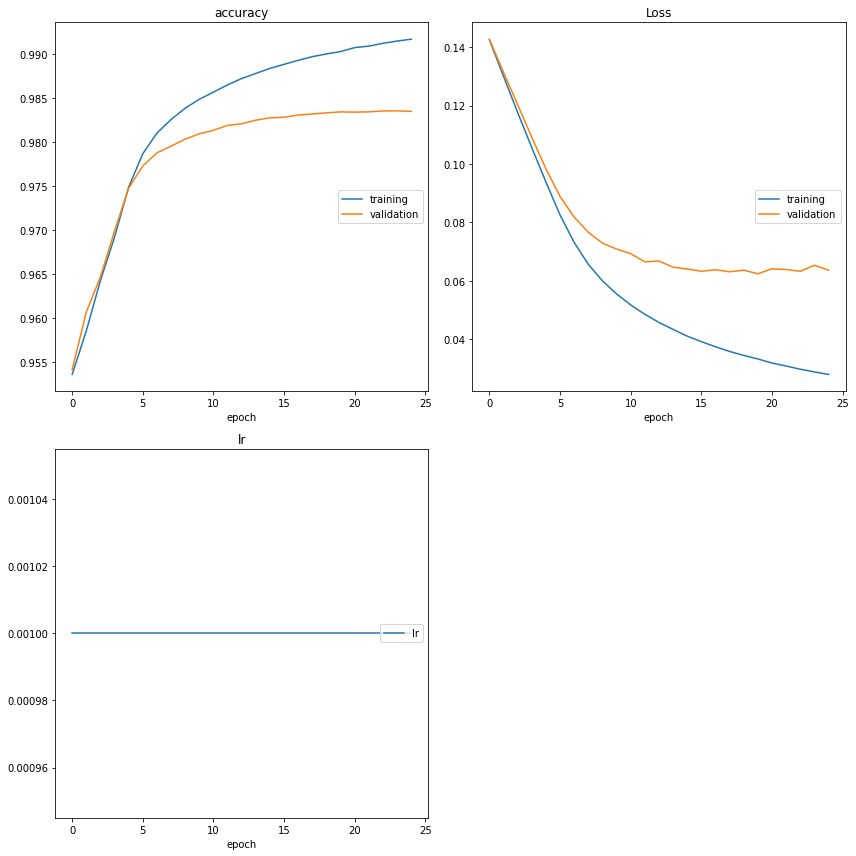

accuracy
	training         	 (min:    0.954, max:    0.992, cur:    0.992)
	validation       	 (min:    0.954, max:    0.984, cur:    0.983)
Loss
	training         	 (min:    0.028, max:    0.143, cur:    0.028)
	validation       	 (min:    0.062, max:    0.143, cur:    0.064)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
34/34 [==============================] - 73s 2s/step - loss: 0.0279 - accuracy: 0.9917 - val_loss: 0.0636 - val_accuracy: 0.9835
Epoch 00025: early stopping


In [103]:
history = model.fit(X_train, y_train, epochs = 25, batch_size = 1024, validation_split = 0.2, callbacks = callbacks)

### Evaluating the Model

In [104]:
model.evaluate(X_test, y_test)

150/150 [==============================] - 4s 26ms/step - loss: 0.0636 - accuracy: 0.9833


[0.06364179402589798, 0.9832819104194641]

### Predicting

In [169]:
pred = model.predict(X_test[100])

In [170]:
pred = np.argmax(pred, axis = -1)

In [171]:
pred

array([[ 3],
       [ 3],
       [16],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3],
       [ 3]])

In [175]:
tags[pred[0][0]]

'O'

In [174]:
pred[0][0]

3

In [176]:
import joblib

In [177]:
joblib.dump(tags, 'tags.pickle')

['tags.pickle']